In [1]:
bicycle = "http://josephsalmon.eu/enseignement/datasets/bicycle_db.csv"
path_bicycle = "./data/bicycle.txt"
pollution = "http://josephsalmon.eu/enseignement/datasets/Mesure_journaliere_Region_Occitanie_Polluants_Principaux.csv"

In [72]:
from download import download
import patsy
import numpy as np
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from scipy.stats import t

sns.set_palette("colorblind")

%matplotlib notebook

In [73]:
download(bicycle, path_bicycle, replace=False)

Replace is False and data exists, so doing nothing. Use replace=True to re-download the data.


'./data/bicycle.txt'

# Bike data

In [74]:
df_bicycle = pd.read_csv(path_bicycle, sep=",", skiprows=2, converters={"heure": str})
pd.options.display.max_columns = 39
df_bicycle.head()

/home/tanglef/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,identifiant accident,date,mois,jour,heure,departement,commune,lat,lon,en agglomeration,type intersection,type collision,luminosite,conditions atmosperiques,type route,circulation,nb voies,profil long route,trace plan route,largeur TPC,largeur route,etat surface,amenagement,situation,categorie usager,gravite accident,sexe,age,motif deplacement,existence securite,usage securite,obstacle fixe heurte,obstacle mobile heurte,localisation choc,manoeuvre avant accident,identifiant vehicule,type autres vehicules,manoeuvre autres vehicules,nombre autres vehicules
0,200500000030,2005-01-13,01 - janvier,3 - jeudi,19,62,62331,50.300,2.840,oui,Hors intersection,Deux véhicules - par le coté,Nuit avec éclairage public allumé,Normale,Route Départementale,NaN,NaN,NaN,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,57-58,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Côté gauche,Changeant de file à gauche,200500000030B02,Transport en commun,Dépassant à gauche,1.0
1,200500000034,2005-01-19,01 - janvier,2 - mercredi,10,62,62022,0.000,0.000,non,Hors intersection,Deux véhicules - frontale,Plein jour,Temps éblouissant,Route Départementale,NaN,NaN,Plat,En courbe à droite,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,M,19-20,Promenade - loisirs,NaN,NaN,NaN,Véhicule,Avant,Sans changement de direction,200500000034B02,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...",Tournant à gauche,1.0
2,200500000078,2005-01-26,01 - janvier,2 - mercredi,13,02,02173,0.000,0.000,non,Autre intersection,Deux véhicules - par le coté,Plein jour,Normale,Route Départementale,NaN,2.0,Pente,Partie rectiligne,NaN,NaN,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,70-71,Promenade - loisirs,Casque,Non,NaN,Véhicule,Avant,Sans changement de direction,200500000078B02,VL seul,Tournant à gauche,1.0
3,200500000093,2005-01-03,01 - janvier,0 - lundi,13,02,02810,49.255,3.094,oui,Hors intersection,Deux véhicules - frontale,Plein jour,Normale,Route Départementale,NaN,NaN,Plat,En courbe à gauche,NaN,52.0,normale,NaN,Sur chaussée,Conducteur,2 - Blessé hospitalisé,F,50-51,Utilisation professionnelle,NaN,NaN,NaN,Véhicule,Avant gauche,Manœuvre d’évitement,200500000093B02,VL seul,Manœuvre d’évitement,1.0
4,200500000170,2005-01-29,01 - janvier,5 - samedi,18,76,76196,0.000,0.000,non,Hors intersection,Deux véhicules - par l’arrière,Nuit sans éclairage public,Normale,Route Départementale,NaN,2.0,Plat,Partie rectiligne,NaN,50.0,normale,NaN,Sur chaussée,Conducteur,1 - Blessé léger,M,73-74,Promenade - loisirs,Autre,Oui,NaN,Véhicule,Arrière,"Même sens, même file",200500000170A01,"VU seul 1,5T <= PTAC <= 3,5T avec ou sans remo...","Même sens, même file",1.0


In [75]:
df_bicycle = df_bicycle[["date", "mois", "jour", "heure", "departement", "en agglomeration",
                       "conditions atmosperiques", "categorie usager", "gravite accident",
                       "sexe", "age", "existence securite"]]
df_bicycle["heure"].replace("", np.nan, inplace=True)
df_bicycle["age"].replace(["2004-2005", "2016-2017", "2006-2007", "2012-2013", "2013-2014",
                           '2005-2006', "2006-2007"], np.nan, inplace=True)
df_bicycle["existence securite"].replace("Inconnu", np.nan, inplace=True)
df_bicycle.dropna(inplace=True)
df_bicycle.rename(columns = {"conditions atmosperiques": "conditions atmospheriques", "gravite accident": "gravite_accident"}, inplace=True)

for i, name in enumerate(df_bicycle.columns):
    print("\n############################")
    print("Column", name)
    print(df_bicycle[df_bicycle.columns[i]].unique(), "\n")


############################
Column date
['2005-01-26' '2005-01-29' '2005-01-23' ... '2018-12-02' '2018-11-17'
 '2018-12-01'] 


############################
Column mois
['01 - janvier' '02 - février' '03 - mars' '04 - avril' '05 - mai'
 '06 - juin' '07 - juillet' '08 - aout' '09 - septembre' '10 - octobre'
 '11 - novembre' '12 - décembre'] 


############################
Column jour
['2 - mercredi' '5 - samedi' '6 - dimanche' '3 - jeudi' '0 - lundi'
 '4 - vendredi' '1 - mardi'] 


############################
Column heure
['13' '18' '10' '15' '17' '9' '22' '16' '12' '11' '14' '19' '21' '7' '20'
 '6' '8' '3' '23' '4' '5' '2' '1'] 


############################
Column departement
['02' '76' '35' '29' '56' '14' '50' '49' '72' '33' '47' '32' '69' '07'
 '38' '42' '57' '68' '51' '52' '89' '25' '83' '84' '03' '06' '08' '10'
 '12' '13' '17' '21' '24' '26' '31' '34' '37' '40' '41' '44' '45' '54'
 '55' '59' '61' '62' '63' '64' '65' '67' '71' '74' '75' '77' '78' '80'
 '82' '86' '87' '91' '92' 

In [76]:
df_bicycle.head()

,date,mois,jour,heure,departement,en agglomeration,conditions atmospheriques,categorie usager,gravite_accident,sexe,age,existence securite
2,2005-01-26,01 - janvier,2 - mercredi,13,02,non,Normale,Conducteur,1 - Blessé léger,M,70-71,Casque
4,2005-01-29,01 - janvier,5 - samedi,18,76,non,Normale,Conducteur,1 - Blessé léger,M,73-74,Autre
5,2005-01-23,01 - janvier,6 - dimanche,18,35,oui,Normale,Conducteur,2 - Blessé hospitalisé,M,45-46,Casque
8,2005-01-08,01 - janvier,5 - samedi,10,29,non,Normale,Conducteur,2 - Blessé hospitalisé,M,57-58,Casque
9,2005-01-13,01 - janvier,3 - jeudi,15,29,oui,Temps éblouissant,Conducteur,1 - Blessé léger,M,75-76,Casque


In [77]:
df_bicycle.set_index(pd.to_datetime(df_bicycle["heure"] + "/00 "+
                            df_bicycle["date"],
                            format="%H/%M %Y-%m-%d"), inplace=True)
df_bicycle.drop(columns=["date"], inplace=True)
df_bicycle = df_bicycle[df_bicycle.index.year!=2018]
df_bicycle.head()

,mois,jour,heure,departement,en agglomeration,conditions atmospheriques,categorie usager,gravite_accident,sexe,age,existence securite
2005-01-26 13:00:00,01 - janvier,2 - mercredi,13,02,non,Normale,Conducteur,1 - Blessé léger,M,70-71,Casque
2005-01-29 18:00:00,01 - janvier,5 - samedi,18,76,non,Normale,Conducteur,1 - Blessé léger,M,73-74,Autre
2005-01-23 18:00:00,01 - janvier,6 - dimanche,18,35,oui,Normale,Conducteur,2 - Blessé hospitalisé,M,45-46,Casque
2005-01-08 10:00:00,01 - janvier,5 - samedi,10,29,non,Normale,Conducteur,2 - Blessé hospitalisé,M,57-58,Casque
2005-01-13 15:00:00,01 - janvier,3 - jeudi,15,29,oui,Temps éblouissant,Conducteur,1 - Blessé léger,M,75-76,Casque


<IPython.core.display.Javascript object>


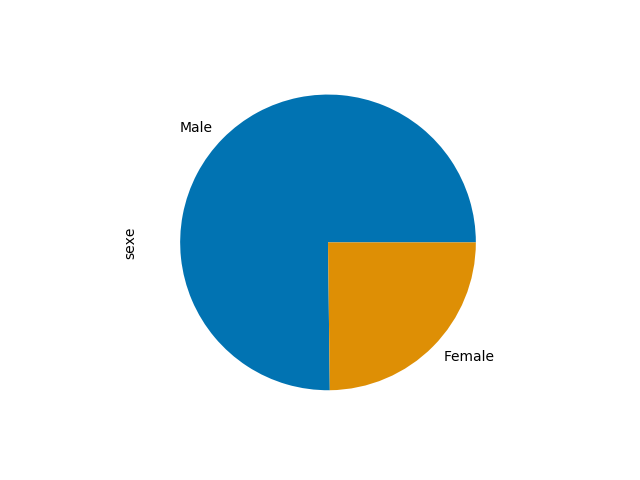

In [79]:
plt.figure()
df_bicycle.sexe.value_counts().plot(kind='pie', labels=["Male", "Female"])
plt.show()

In [9]:
pd.crosstab(df_bicycle['existence securite'], df_bicycle['gravite_accident'], normalize='index', margins=True)*100

gravite_accident,0 - Indemne,1 - Blessé léger,2 - Blessé hospitalisé,3 - Tué
existence securite,,,,
Autre,6.477814,64.998747,26.698421,1.825019
Casque,6.689238,56.937633,32.841819,3.531310
Ceinture,3.819444,15.208333,70.625000,10.347222
Dispositif enfants,7.142857,58.571429,32.857143,1.428571
Equipement réfléchissant,4.846598,59.715429,31.280569,4.157403
All,6.400723,58.906109,31.536243,3.156925


In [10]:
df_bicycle["heure"] = pd.to_numeric(df_bicycle["heure"])

<IPython.core.display.Javascript object>


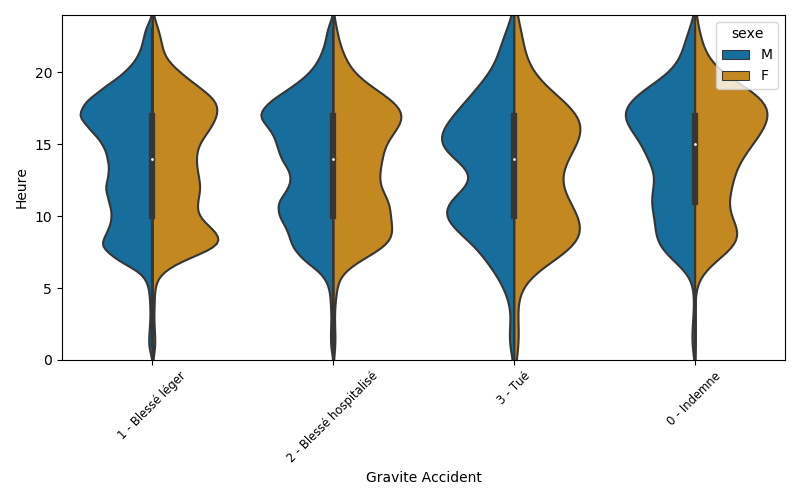

In [11]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.violinplot(x="gravite_accident", y="heure", data=df_bicycle)
ax.set_xlabel('Accident gravity')
ax.set_ylabel('Hour')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='small')
plt.ylim([0,24])
plt.title("When are happening the most dangerous accidents?")
plt.tight_layout()
plt.show()

In [19]:
lm_time_gravity = ols('heure ~ C(gravite_accident)', data=df_bicycle).fit()

In [13]:
anova_time_grav = sm.stats.anova_lm(lm_time_gravity, typ=2)
anova_time_grav

,sum_sq,df,F,PR(>F)
C(gravite_accident),1.434362e+03,3.0,24.909024,4.244728e-16
Residual,1.104692e+06,57552.0,NaN,NaN


<IPython.core.display.Javascript object>


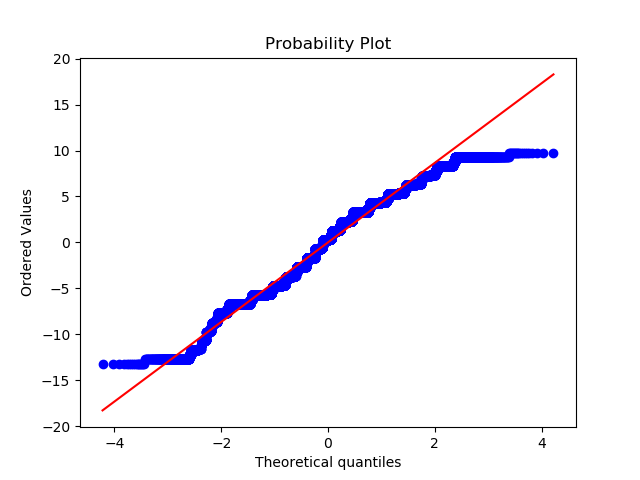

In [14]:
resid = lm_time_gravity.resid
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(resid, plot=ax, fit=True)

## Visualize some things

<IPython.core.display.Javascript object>


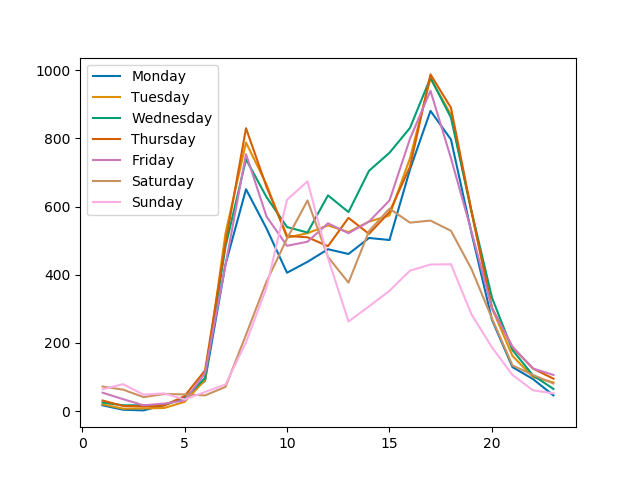

In [85]:
df_bicycle.groupby([df_bicycle.index.weekday, df_bicycle.index.hour])[
    'sexe'].count().unstack(level=0).plot()
plt.legend(labels=['Monday', "Tuesday", "Wednesday",
                   "Thursday", "Friday", "Saturday", "Sunday"])
plt.show()

<IPython.core.display.Javascript object>


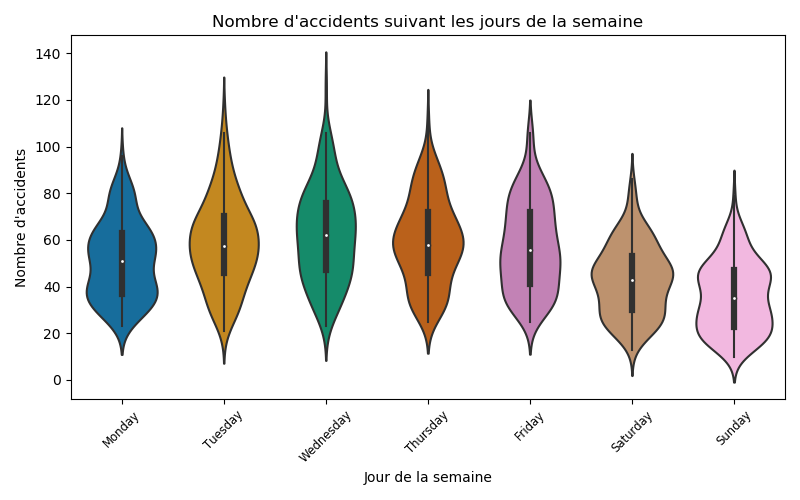

In [20]:
data_days = df_bicycle.to_period("M")
data_days = data_days.pivot_table(index=data_days.index, columns='jour', aggfunc='size')

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_days = pd.DataFrame({"days": days*int(data_days.shape[0]),
                         "number_accident": data_days.stack().values})


fig, ax = plt.subplots(figsize=(8,5))
ax = sns.violinplot(x="days", y="number_accident", data=data_days)
ax.set_ylabel("Nombre d'accidents")
ax.set_xlabel('Jour de la semaine')
plt.title("Nombre d'accidents suivant les jours de la semaine")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='small')
plt.tight_layout()
plt.show()

                 sum_sq      df          F        PR(>F)
C(days)    90482.483516     6.0  47.806246  3.554817e-52
Residual  342261.743590  1085.0        NaN           NaN


<IPython.core.display.Javascript object>


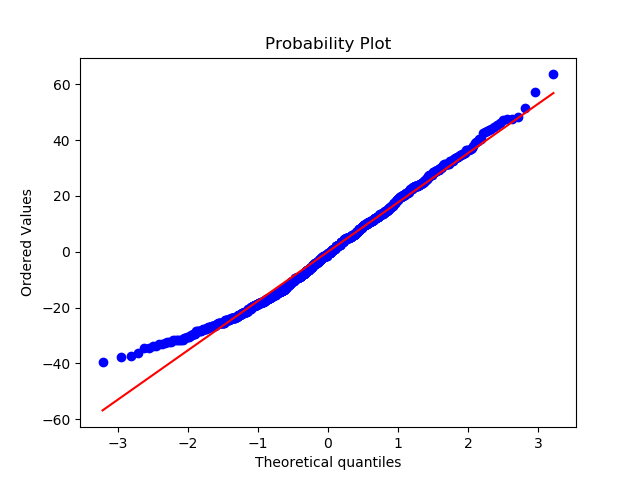

In [21]:
lm_days = ols('number_accident ~ C(days)', data=data_days).fit()
anova_days = sm.stats.anova_lm(lm_days, typ=2)
print(anova_days)

resid_days = lm_days.resid
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(resid_days, plot=ax, fit=True)

## 2nd anova

In [103]:
heures = df_bicycle.heure.isin(["6", "7", '8', '9', '10', "11", '12', '13', "14", "15", "16", "17", "18", "19", "20"])
df_all = df_bicycle[heures]
df_all = df_all.copy()
df_all["daytime"] = df_all.heure.isin(["6", "7", '8', '9', '10', "11", '12', "13"])
df_all['daytime'].replace(True, "matin", inplace=True)
df_all['daytime'].replace(False, "apres_midi", inplace=True)
df_all.head()

,mois,jour,heure,departement,en agglomeration,conditions atmospheriques,categorie usager,gravite_accident,sexe,age,existence securite,daytime
2005-01-26 13:00:00,01 - janvier,2 - mercredi,13,02,non,Normale,Conducteur,1 - Blessé léger,M,70-71,Casque,matin
2005-01-29 18:00:00,01 - janvier,5 - samedi,18,76,non,Normale,Conducteur,1 - Blessé léger,M,73-74,Autre,apres_midi
2005-01-23 18:00:00,01 - janvier,6 - dimanche,18,35,oui,Normale,Conducteur,2 - Blessé hospitalisé,M,45-46,Casque,apres_midi
2005-01-08 10:00:00,01 - janvier,5 - samedi,10,29,non,Normale,Conducteur,2 - Blessé hospitalisé,M,57-58,Casque,matin
2005-01-13 15:00:00,01 - janvier,3 - jeudi,15,29,oui,Temps éblouissant,Conducteur,1 - Blessé léger,M,75-76,Casque,apres_midi


<IPython.core.display.Javascript object>


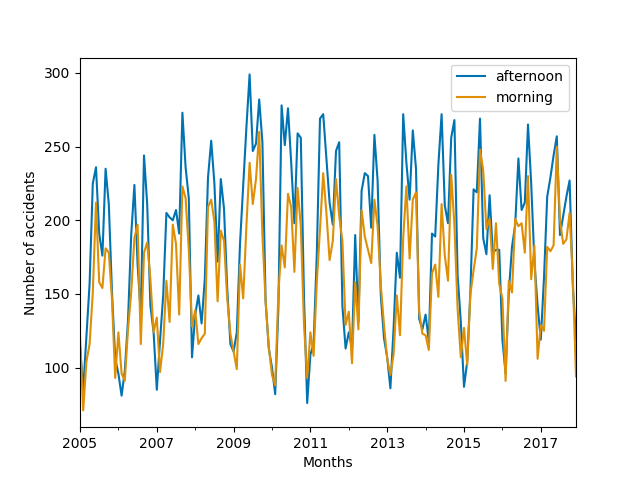

In [104]:
data = df_all.to_period("M")
data = data.pivot_table(index=data.index, columns='daytime', aggfunc='size')
data.plot()
plt.ylabel("Number of accidents")
plt.xlabel("Months")
plt.legend(labels=['afternoon', "morning"])
plt.show()

In [92]:
data = pd.DataFrame({"accident_number": data.stack().values,
                     "daytime": ['6-13h', '14-20h']*int(data.shape[0])})
data

,accident_number,daytime
0,115,6-13h
1,6-13h,14-20h
2,121,6-13h
3,14-20h,14-20h
4,85,6-13h
...,...,...
619,14-20h,14-20h
620,119,6-13h
621,6-13h,14-20h
622,94,6-13h


<IPython.core.display.Javascript object>


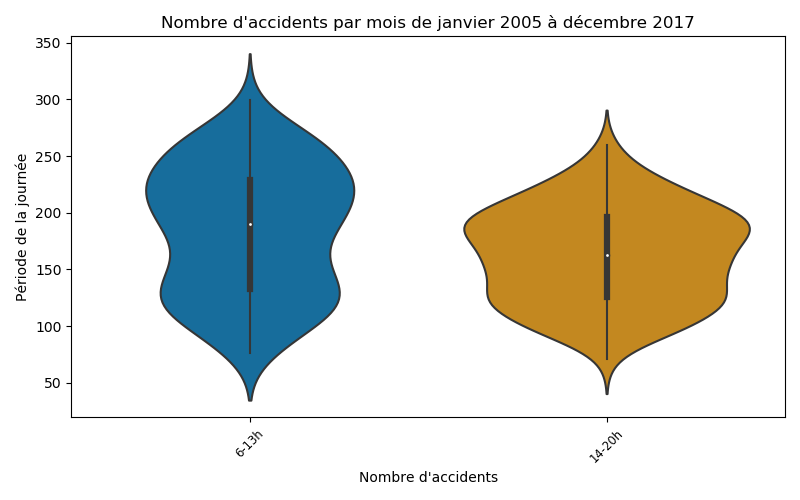

In [45]:
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.violinplot(x="daytime", y="accident_number", data=data)
ax.set_xlabel("Nombre d'accidents")
ax.set_ylabel('Période de la journée')
plt.title("Nombre d'accidents par mois de janvier 2005 à décembre 2017")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize='small')
plt.tight_layout()
plt.show()

In [46]:
lm_acc_day = ols('accident_number ~ C(daytime)', data=data).fit()
anova_acc_day = sm.stats.anova_lm(lm_acc_day, typ=2)
anova_acc_day

,sum_sq,df,F,PR(>F)
C(daytime),37422.721154,1.0,15.070963,0.000127
Residual,769761.250000,310.0,NaN,NaN


<IPython.core.display.Javascript object>


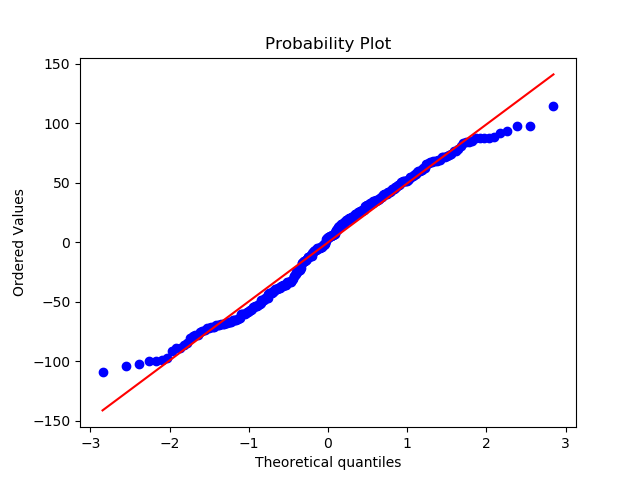

In [47]:
resid_acc = lm_acc_day.resid
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(resid_acc, plot=ax, fit=True)

## Permutation test
Protocol:
* 2 groups A=control and B=test, we test the effect of the treatment
* H0 : mu_A >= mu_B (reject H0 means better treatment)
* set seed
* Assign values for the effect of the treatment (or placebo)
* Test stat = mu_test - mu_contral
* shuffle and recalculate the Test_stat J times big (in theory C_na^nA+nb
* plot the hist of the values
* p-val= number of stats over the first / J

In [69]:
class Treatment_test_simulation():

    def __init__(self, nb_patients, mean_A=None, mean_B=None, nb_permut=None, setseed=True):
        if (nb_patients % 2) != 0:
            nb_patients += 1  # only even number is easier
        self.n = nb_patients
        if mean_A is None:  # A=control ie gaussian mean effect is 5
            mean_A = 4  # 5
            # B : miracle drug without memory in the system and
        if mean_B is None:
            mean_B = 7  # B = test ie exponential mean effect is 7
        self.mean_A = mean_A
        self.mean_B = mean_B

        if nb_permut is None:  # alright for large numbers
            nb_permut = 100 * nb_patients
        self.nb_permut = nb_permut
        self.setseed = setseed
        if setseed:
            np.random.seed(11235813)

        self.group_A = np.random.normal(size=int(self.n/2),
                                        loc=self.mean_A)
        self.group_B = np.random.exponential(size=int(self.n/2),
                                             scale=self.mean_B)  # 1/lambda in python

    @staticmethod
    def compute_stat(rowtab):
        res = np.mean(rowtab[1, :]) - np.mean(rowtab[0, :])
        return res

    def permutation_test(self):
        J = self.nb_permut
        if self.setseed:
            rng = np.random.default_rng(seed=11235813)
        storage = np.zeros(J)
        row_tab = np.vstack((self.group_A, self.group_B))
        for j in range(J):
            data = row_tab.copy()
            rng.shuffle(data.reshape(-1), axis=0)
            storage[j] = self.compute_stat(data)
        return storage

    def plot_hist(self, storage):
        plt.figure()
        sns.distplot(storage)
        plt.show()

    def answer_test(self, storage):
        row_tab = np.vstack((self.group_A, self.group_B))
        ref_ = self.compute_stat(row_tab)
        nb_over_ref = np.sum(storage >= ref_)
        return nb_over_ref / self.nb_permut, ref_

    def perform_test(self, plot=True):
        stor = self.permutation_test()
        pval, ref_ = self.answer_test(stor)
        if plot:
            self.plot_hist(stor)
            plt.axvline(x=ref_, linewidth=2, color='r',
                        label=r'$reference\ value: \hat\mu_B - \hat\mu_A$')
            plt.ylabel("density")
            plt.xlabel("Test values for each permutation")
            plt.legend()
        return pval, ref_

<IPython.core.display.Javascript object>


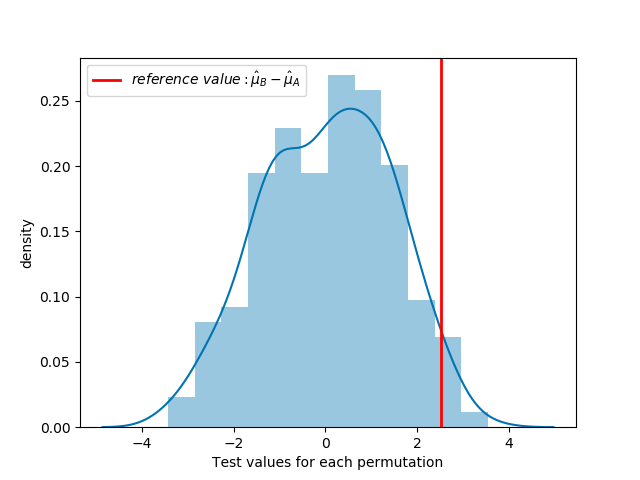

(0.03, 2.516236836730584)

In [70]:
test = Treatment_test_simulation(50, setseed=True, nb_permut=300)
test.perform_test()

<IPython.core.display.Javascript object>


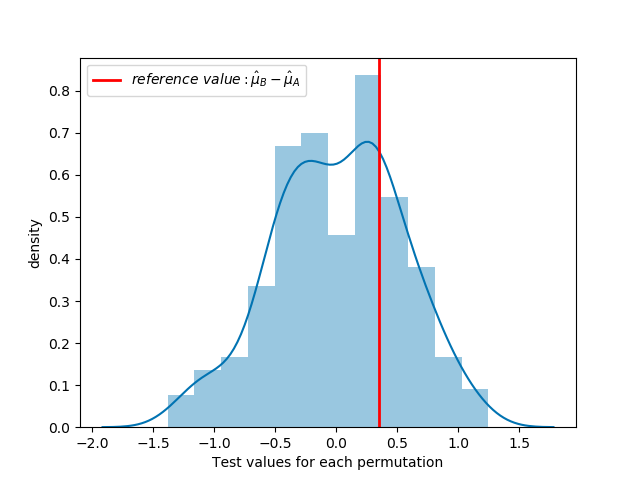

(0.27666666666666667, 0.3458037734920356)

In [71]:
testNot = Treatment_test_simulation(50, mean_A = 2, mean_B = 2.5, setseed=True, nb_permut=300)
testNot.perform_test()